# Prétraitement

## Import & Base

In [45]:
# Versions & imports de base
import sys, os, platform
import numpy as np
import PIL
import cv2
import matplotlib
import matplotlib.pyplot as plt

print({
    'python': sys.version,
    'os': platform.platform(),
    'numpy': np.__version__,
    'pillow': PIL.__version__,
    'opencv': cv2.__version__,
    'matplotlib': matplotlib.__version__,
})

# Chemins
BASE_DIR = r"d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8"
DATA_DIR = os.path.join(BASE_DIR, 'DATA')
IMG_DIR = os.path.join(DATA_DIR, 'P8_Cityscapes_leftImg8bit_trainvaltest', 'leftImg8bit')
GT_DIR  = os.path.join(DATA_DIR, 'P8_Cityscapes_gtFine_trainvaltest', 'gtFine')

for p in [BASE_DIR, DATA_DIR, IMG_DIR, GT_DIR]:
    print(p, os.path.exists(p))


{'python': '3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]', 'os': 'Windows-10-10.0.26100-SP0', 'numpy': '1.26.4', 'pillow': '10.3.0', 'opencv': '4.11.0', 'matplotlib': '3.8.4'}
d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8 True
d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA True
d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit True
d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\P8_Cityscapes_gtFine_trainvaltest\gtFine True


## Fonctions utilitaires – simple et fonctionnel

- Chargement d'une paire image/masque
- Conversion Cityscapes (labelIds) vers 8 classes (+ ignore)
- Colorisation pour visualisation
- Démo d'utilisation


In [46]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

# Mapping Cityscapes
labelId_to_8 = {
    # void & similaires
    -1:7, 0:7, 1:7, 2:7, 3:7, 4:7, 5:7, 6:7,
    7:0,   # road -> flat
    8:0,   # sidewalk -> flat
    9:7,   # parking (sera corrigé juste après)
    10:0,  # rail track -> flat
    11:1,  # building -> construction
    12:1,  # wall -> construction
    13:1,  # fence -> construction
    14:1,  # guard rail -> construction
    15:1,  # bridge -> construction
    16:1,  # tunnel -> construction
    17:2,  # pole -> object
    18:2,  # polegroup -> object
    19:2,  # traffic light -> object
    20:2,  # traffic sign -> object
    21:3,  # vegetation -> nature
    22:3,  # terrain -> nature
    23:4,  # sky -> sky
    24:5,  # person -> human
    25:5,  # rider -> human
    26:6,  # car -> vehicle
    27:6,  # truck -> vehicle
    28:6,  # bus -> vehicle
    29:6,  # caravan -> vehicle
    30:6,  # trailer -> vehicle
    31:6,  # train -> vehicle
    32:6,  # motorcycle -> vehicle
    33:6,  # bicycle -> vehicle
}
# Correction classique: parking (9) -> flat (0)
labelId_to_8[9] = 0

# Couleurs pour visualisation (RGB)
PALETTE_8 = np.array([
    [128,  64, 128],  # flat
    [ 70,  70,  70],  # construction
    [153, 153, 153],  # object
    [107, 142,  35],  # nature
    [ 70, 130, 180],  # sky
    [220,  20,  60],  # human
    [  0,   0, 142],  # vehicle
    [  0,   0,   0],  # void
], dtype=np.uint8)

# Indice spécial pour ignorer les pixels 'void' pendant l'entraînement
IGNORE_INDEX = 255


def trouver_une_paire_image_masque(find_one_pair=True, split='val'):
    """Trouve une paire (image RGB, masque labelIds) pour un split donné.
    Simpliste: prend le premier fichier trouvé qui matche par préfixe.
    Returns: (img_path, gt_path) ou (None, None)
    """
    cities = sorted(os.listdir(os.path.join(IMG_DIR, split)))
    for city in cities:
        img_files = sorted(glob(os.path.join(IMG_DIR, split, city, '*_leftImg8bit.png')))
        gt_files  = sorted(glob(os.path.join(GT_DIR, split, city, '*_gtFine_labelIds.png')))
        if not img_files or not gt_files:
            continue
        # on cherche un id commun (préfixe commun)
        for img_fp in img_files:
            img_id = Path(img_fp).name.replace('_leftImg8bit.png', '')
            matches = [g for g in gt_files if Path(g).name.startswith(img_id)]
            if matches:
                return img_fp, matches[0]
    return None, None


def lire_image_rgb(read_image_rgb_path):
    """Lit une image en RGB (lit en BGR par défaut)."""
    bgr = cv2.imread(read_image_rgb_path)
    if bgr is None:
        raise FileNotFoundError(f"Image introuvable: {read_image_rgb_path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb


def lire_masque_labelIds(read_mask_path):
    """Lit un masque Cityscapes en labelIds."""
    mask = cv2.imread(read_mask_path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        raise FileNotFoundError(f"Masque introuvable: {read_mask_path}")
    return mask


def convertir_labelIds_vers_8classes(mask_label_ids):
    """Convertit un masque labelIds en masque 8-classes (0..6) + ignore (255).
    Implémentation volontairement simple/moins optimisée.
    """
    h, w = mask_label_ids.shape
    out = np.full((h, w), IGNORE_INDEX, dtype=np.uint8)
    for lid, cat8 in labelId_to_8.items():
        # cat8 == 7 => void => on met IGNORE_INDEX (255)
        if cat8 == 7:
            out[mask_label_ids == lid] = IGNORE_INDEX
        else:
            out[mask_label_ids == lid] = cat8
    return out


def coloriser_masque_8classes(mask_8):
    """Colorise un masque 8-classes en RGB avec la palette définie."""
    h, w = mask_8.shape
    # Initialisation d'une image RGB vide pour coloriser le masque 8-classes
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for k in range(7):
        rgb[mask_8 == k] = PALETTE_8[k]
    rgb[mask_8 == IGNORE_INDEX] = PALETTE_8[7]
    return rgb


def afficher_triplet_image_masks(image_rgb, mask_label_ids, mask_8, title_prefix="Demo"):
    """Affiche côte à côte: image RGB, masque labelIds, masque 8-classes colorisé."""
    rgb8 = coloriser_masque_8classes(mask_8)
    fig, axs = plt.subplots(1,3, figsize=(16,5))
    axs[0].imshow(image_rgb); axs[0].set_title(f"{title_prefix} - Image")
    axs[1].imshow(mask_label_ids, cmap='nipy_spectral'); axs[1].set_title(f"{title_prefix} - labelIds")
    axs[2].imshow(rgb8); axs[2].set_title(f"{title_prefix} - 8 classes")
    for a in axs: a.axis('off')
    plt.show()


def charger_et_convertir_un_exemple(split='val'):
    """Pipeline simple: trouve une paire, lit image+masque, convertit en 8 classes."""
    img_path, gt_path = trouver_une_paire_image_masque(split=split)
    if not img_path or not gt_path:
        raise RuntimeError("Impossible de trouver une paire image/masque valide.")
    img_rgb = lire_image_rgb(img_path)
    gt_ids  = lire_masque_labelIds(gt_path)
    mask8   = convertir_labelIds_vers_8classes(gt_ids)
    return img_rgb, gt_ids, mask8, img_path, gt_path


### Démo 8 classes

Image : d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\P8_Cityscapes_leftImg8bit_trainvaltest\leftImg8bit\val\frankfurt\frankfurt_000000_000294_leftImg8bit.png
Masque: d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\P8_Cityscapes_gtFine_trainvaltest\gtFine\val\frankfurt\frankfurt_000000_000294_gtFine_labelIds.png


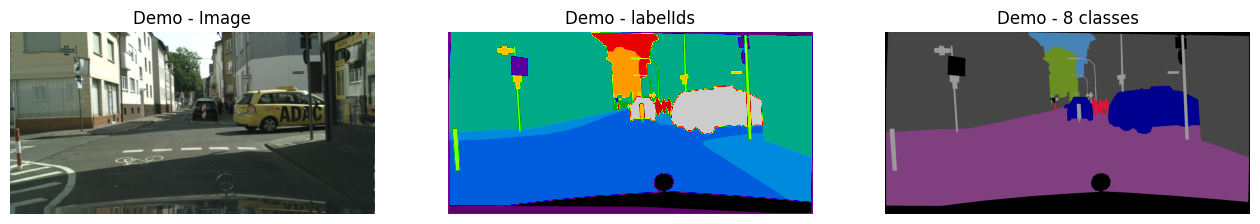

In [47]:
# Démo simple
try:
    img_rgb, gt_ids, mask8, ipath, gpath = charger_et_convertir_un_exemple('val')
    print('Image :', ipath)
    print('Masque:', gpath)
    afficher_triplet_image_masks(img_rgb, gt_ids, mask8)
except Exception as e:
    print('Erreur pendant la démo:', e)


## Générateur de données & data augmentation

### Générateur

In [48]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import cv2
import albumentations as A


def collect_pairs(split='train'):
    pairs = []
    cities = sorted(os.listdir(os.path.join(IMG_DIR, split)))
    for city in cities:
        img_files = sorted(glob(os.path.join(IMG_DIR, split, city, '*_leftImg8bit.png')))
        gt_files  = sorted(glob(os.path.join(GT_DIR,  split, city, '*_gtFine_labelIds.png')))
        if not img_files or not gt_files:
            continue
        gt_index = {Path(p).name.replace('_gtFine_labelIds.png',''): p for p in gt_files}
        for ip in img_files:
            img_id = Path(ip).name.replace('_leftImg8bit.png','')
            gp = gt_index.get(img_id)
            if gp:
                pairs.append((ip, gp))
    return pairs


def build_aug(img_h=256, img_w=512):
    return A.Compose([
        A.Resize(img_h, img_w, interpolation=cv2.INTER_LINEAR),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.3, -0.1), contrast_limit=0.2),
        A.RandomGamma(p=0.4, gamma_limit=(80, 120)),
        A.GaussianBlur(p=0.3, blur_limit=(3, 7)),
        A.RandomSnow(p=0.4, snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5),
        A.RandomFog(p=0.2, fog_coef_lower=0.1, fog_coef_upper=0.3, alpha_coef=0.08),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10,
                           border_mode=cv2.BORDER_CONSTANT, value=(0,0,0), mask_value=IGNORE_INDEX, p=0.5),
    ])


def data_generator(split='train', batch_size=4, img_size=(256, 512), shuffle=True, augment=True):
    pairs = collect_pairs(split)
    indices = np.arange(len(pairs))
    aug = build_aug(img_h=img_size[0], img_w=img_size[1]) if augment else None
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, len(indices), batch_size):
            batch_idx = indices[start:start+batch_size]
            images, masks = [], []
            for j in batch_idx:
                ip, gp = pairs[j]
                img = lire_image_rgb(ip)
                mask_ids = lire_masque_labelIds(gp)
                mask8 = convertir_labelIds_vers_8classes(mask_ids)
                if aug is not None:
                    out = aug(image=img, mask=mask8)
                    img = out['image']
                    mask8 = out['mask']
                else:
                    img = cv2.resize(img, (img_size[1], img_size[0]), interpolation=cv2.INTER_LINEAR)
                    mask8 = cv2.resize(mask8, (img_size[1], img_size[0]), interpolation=cv2.INTER_NEAREST)
                images.append(img)
                masks.append(mask8)
            yield np.stack(images), np.stack(masks)


### Démo

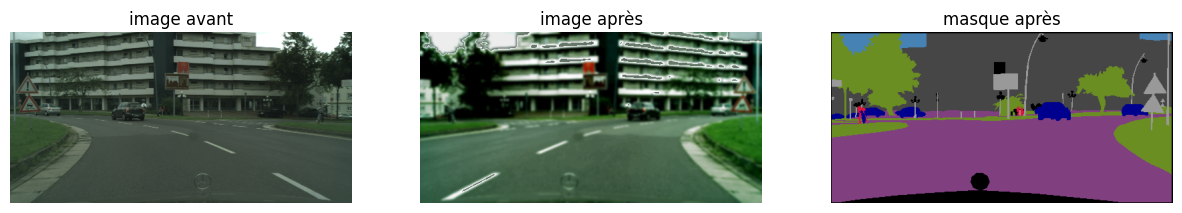

In [49]:
# Avant/Après (image et masque)
try:
    ipath, gpath = trouver_une_paire_image_masque(split='train')
    img = lire_image_rgb(ipath)
    mask_ids = lire_masque_labelIds(gpath)
    mask8 = convertir_labelIds_vers_8classes(mask_ids)

    aug = build_aug(img_h=256, img_w=512)
    out = aug(image=img, mask=mask8)
    img_aug = out['image']
    mask_aug = out['mask']

    img0 = cv2.resize(img, (512, 256), interpolation=cv2.INTER_LINEAR)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img0); axs[0].set_title('image avant'); axs[0].axis('off')
    axs[1].imshow(img_aug); axs[1].set_title('image après'); axs[1].axis('off')
    axs[2].imshow(coloriser_masque_8classes(mask_aug)); axs[2].set_title('masque après'); axs[2].axis('off')
    plt.show()
except Exception as e:
    print('Erreur demo:', e)


### Génération et save de toutes les images avec data augmentation

In [50]:
# Configuration des sorties et helpers de sauvegarde
import json
from tqdm import tqdm

OUT_DIR = os.path.join(DATA_DIR, 'PROCESSED_256x512_augtrain')
IMG_OUT = os.path.join(OUT_DIR, 'images')
MSK_OUT = os.path.join(OUT_DIR, 'masks')
os.makedirs(IMG_OUT, exist_ok=True)
os.makedirs(MSK_OUT, exist_ok=True)

# Sauvegarde PNG 8-bit pour images (RGB) et masques (uint8, avec 255 pour ignore)
# Sous-dossiers par split et par ville pour garder la structure Cityscapes

def save_triplet(img_np, mask_np, split, city, sample_id):
    img_dir = os.path.join(IMG_OUT, split, city)
    msk_dir = os.path.join(MSK_OUT, split, city)
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(msk_dir, exist_ok=True)
    img_fp = os.path.join(img_dir, f"{sample_id}.png")
    msk_fp = os.path.join(msk_dir, f"{sample_id}.png")
    # OpenCV attend BGR
    bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    cv2.imwrite(img_fp, bgr)
    cv2.imwrite(msk_fp, mask_np)
    return img_fp, msk_fp


def parse_city_and_id(img_path):
    # Exemple: .../leftImg8bit/train/frankfurt/frankfurt_000000_000294_leftImg8bit.png
    city = Path(img_path).parent.name
    sample_id = Path(img_path).name.replace('_leftImg8bit.png','')
    return city, sample_id


def generate_and_save_split(split='train', img_size=(256,512), augment=False, limit=None, seed=42):
    rng = np.random.default_rng(seed)
    pairs = collect_pairs(split)
    if limit is not None:
        pairs = pairs[:limit]
    aug = build_aug(img_h=img_size[0], img_w=img_size[1]) if augment else None

    saved = []
    for ip, gp in tqdm(pairs, desc=f"{split} -> save", total=len(pairs)):
        img = lire_image_rgb(ip)
        mask_ids = lire_masque_labelIds(gp)
        mask8 = convertir_labelIds_vers_8classes(mask_ids)
        if aug is not None:
            out = aug(image=img, mask=mask8)
            img = out['image']
            mask8 = out['mask']
        else:
            img = cv2.resize(img, (img_size[1], img_size[0]), interpolation=cv2.INTER_LINEAR)
            mask8 = cv2.resize(mask8, (img_size[1], img_size[0]), interpolation=cv2.INTER_NEAREST)
        city, sid = parse_city_and_id(ip)
        img_fp, msk_fp = save_triplet(img, mask8, split, city, sid)
        saved.append((img_fp, msk_fp))
    return saved



In [51]:
# Script de génération: train avec augmentation, val/test sans
IMG_SIZE = (256, 512)

# Limite optionnelle pour debug rapide (mettre None pour faire tout le split)
LIMIT_DEBUG = None  # ex: 20

from glob import glob

def split_has_images(split):
    # Vérifie si des images ont déjà été générées pour ce split
    return len(glob(os.path.join(IMG_OUT, split, '*', '*.png'))) > 0

report = {}
for split, augment in [('train', True), ('val', False), ('test', False)]:
    if split_has_images(split):
        existing = len(glob(os.path.join(IMG_OUT, split, '*', '*.png')))
        print(f"{split}: images déjà présentes ({existing}), on saute.")
        report[split] = f"existing:{existing}"
        continue
    saved = generate_and_save_split(split=split, img_size=IMG_SIZE, augment=augment, limit=LIMIT_DEBUG)
    report[split] = len(saved)

print('Echantillons sauvegardés:', report)
print('Dossiers:')
print(' - images ->', IMG_OUT)
print(' - masks  ->', MSK_OUT)


train: images déjà présentes (2975), on saute.
val: images déjà présentes (500), on saute.
test: images déjà présentes (1525), on saute.
Echantillons sauvegardés: {'train': 'existing:2975', 'val': 'existing:500', 'test': 'existing:1525'}
Dossiers:
 - images -> d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\PROCESSED_256x512_augtrain\images
 - masks  -> d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\PROCESSED_256x512_augtrain\masks


### Démo finale

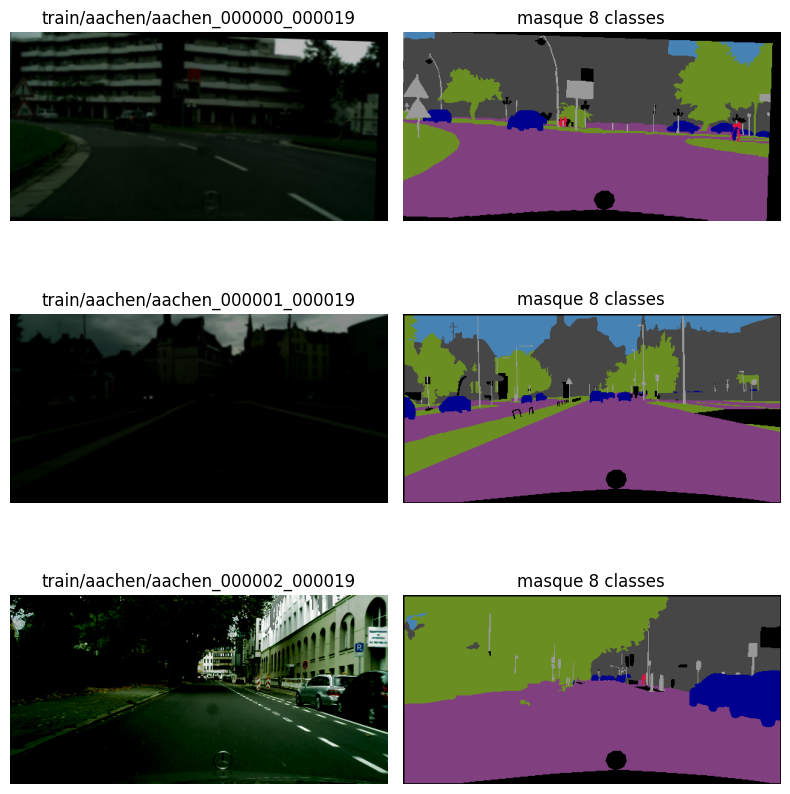

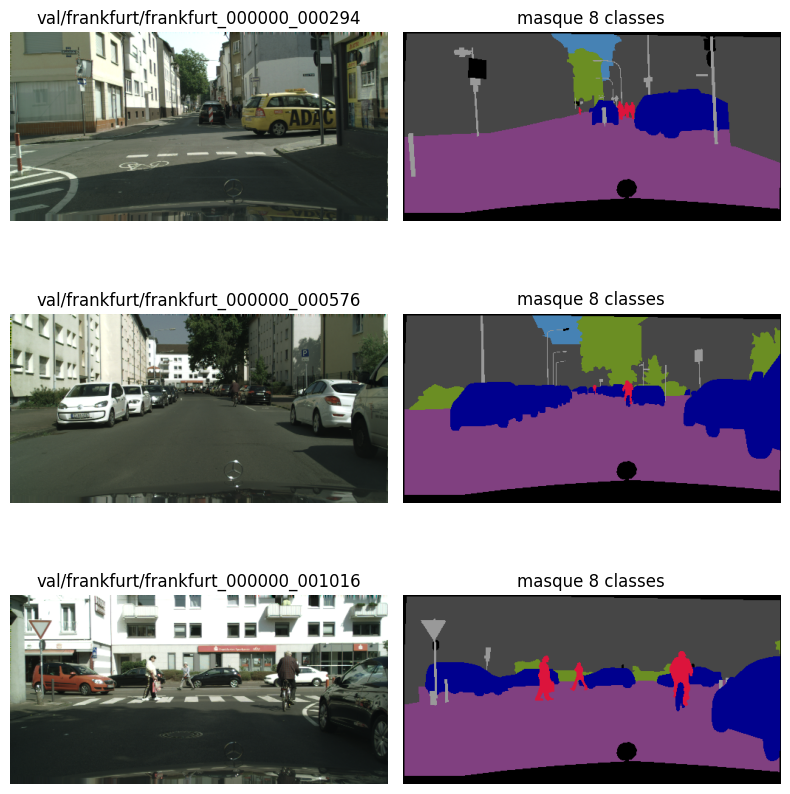

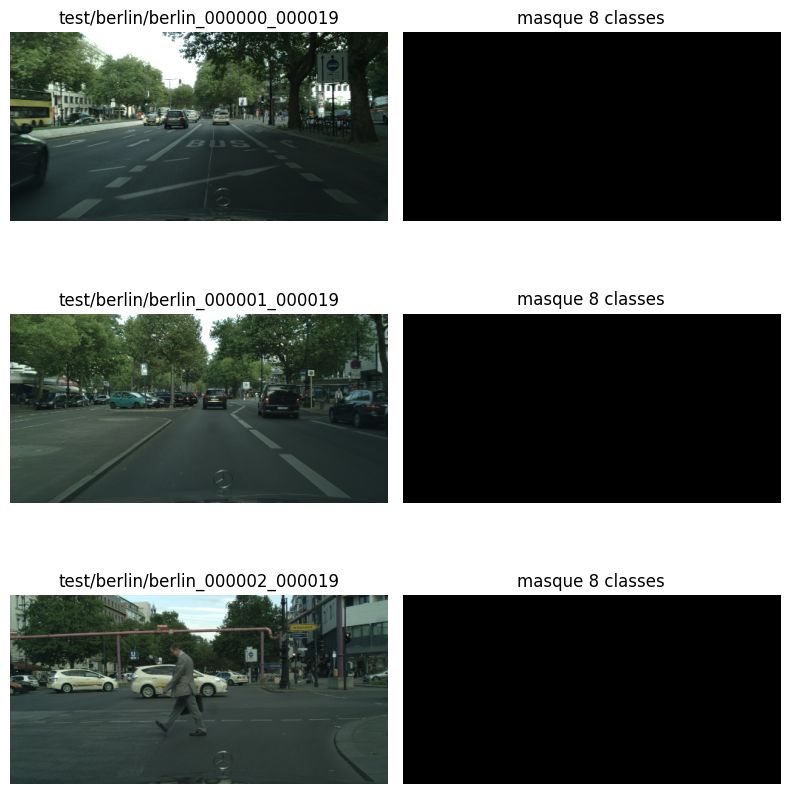

In [52]:
# Prévisualisation de quelques exemples sauvegardés
from glob import glob

def show_samples(split='train', n=3):
    img_paths = sorted(glob(os.path.join(IMG_OUT, split, '*', '*.png')))
    if len(img_paths) == 0:
        print('Aucune image trouvée dans', os.path.join(IMG_OUT, split))
        return
    picks = img_paths[:n]
    fig, axs = plt.subplots(n, 2, figsize=(8, 3*n))
    if n == 1:
        axs = np.array([axs])
    for i, ip in enumerate(picks):
        city = Path(ip).parent.name
        sid  = Path(ip).name.replace('.png','')
        mp = os.path.join(MSK_OUT, split, city, sid+'.png')
        img = lire_image_rgb(ip)
        mask8 = cv2.imread(mp, cv2.IMREAD_UNCHANGED)
        axs[i,0].imshow(img); axs[i,0].set_title(f'{split}/{city}/{sid}'); axs[i,0].axis('off')
        axs[i,1].imshow(coloriser_masque_8classes(mask8)); axs[i,1].set_title('masque 8 classes'); axs[i,1].axis('off')
    plt.tight_layout(); plt.show()

show_samples('train', n=3)
show_samples('val', n=3)
show_samples('test', n=3)


# Entrainement

## Base

In [53]:
# PyTorch: imports et configuration
# - On importe PyTorch et prépare un "device" (GPU si dispo, sinon CPU)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Fixer une graine pour rendre les résultats plus reproductibles
SEED = 42
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# device = 'cuda' (GPU) si possible, sinon 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Optimisations GPU (RTX 5090)
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision('high')
except Exception:
    pass

# Nombre de classes à prédire (0..6), 255 sera ignoré
NUM_CLASSES = 7

# Taille des mini-lots pour l'entraînement (augmenté)
BATCH_SIZE = 12

# Nombre de workers pour le DataLoader
import os, platform
IS_WINDOWS = (platform.system() == 'Windows')
CPU_COUNT = os.cpu_count() or 8
DATALOADER_WORKERS = 0 if IS_WINDOWS else max(4, min(16, CPU_COUNT - 2))

# Options DataLoader
DATALOADER_PREFETCH = 2
PIN_MEMORY = True

# Option pour torch.compile (désactivé par défaut)
USE_TORCH_COMPILE = False

print('device =', device)


device = cuda


### Diagnostic CUDA / GPU

In [54]:
# Diagnostic CUDA / GPU
import sys, subprocess
print('python:', sys.version)
print('executable:', sys.executable)
print('torch.__version__:', torch.__version__)
print('torch.version.cuda:', torch.version.cuda)
print('torch.cuda.is_available():', torch.cuda.is_available())
print('torch.cuda.device_count():', torch.cuda.device_count())

if torch.cuda.is_available():
    try:
        print('torch.backends.cudnn.version():', torch.backends.cudnn.version())
    except Exception as e:
        print('cudnn version erreur:', e)
    for i in range(torch.cuda.device_count()):
        try:
            print(f'device[{i}]:', torch.cuda.get_device_name(i))
        except Exception as e:
            print(f'device[{i}] erreur:', e)
else:
    print('CUDA non détecté par PyTorch. Tentative nvidia-smi...')
    try:
        out = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT, shell=True, text=True)
        print('\n'.join(out.splitlines()[:8]))
    except Exception as e:
        print('nvidia-smi non disponible depuis ce kernel:', e)

import os
print('CUDA_PATH:', os.environ.get('CUDA_PATH'))


python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
executable: d:\DOCUMENTS\ECOLE\OpenClassroom\Formation IA Engineer\P8\venv\Scripts\python.exe
torch.__version__: 2.10.0.dev20251003+cu128
torch.version.cuda: 12.8
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
torch.backends.cudnn.version(): 91002
device[0]: NVIDIA GeForce RTX 5090
CUDA_PATH: None


### Load Data

In [55]:
# Dataset Cityscapes PNG prétraité
# - Lit les images/masques sauvegardés (256x512) et renvoie des tenseurs
class CityProcessedDataset(Dataset):
    def __init__(self, root_img, root_mask, split='train', normalize=True):
        # On récupère la liste des chemins d'images du split
        self.img_paths = sorted(glob(os.path.join(root_img, split, '*', '*.png')))
        self.root_img = root_img
        self.root_mask = root_mask
        self.split = split
        self.normalize = normalize
        if len(self.img_paths) == 0:
            raise RuntimeError(f'Aucune image trouvée dans {os.path.join(root_img, split)}')

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # On localise l'image et le masque correspondant
        ip = self.img_paths[idx]
        city = Path(ip).parent.name
        sid  = Path(ip).name.replace('.png','')
        mp = os.path.join(self.root_mask, self.split, city, sid+'.png')

        # Image en float32 [0,1], puis normalisation (même que ImageNet)
        img = lire_image_rgb(ip).astype(np.float32) / 255.0
        if self.normalize:
            # Normalisation type ImageNet
            mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
            std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
            img = (img - mean) / std
        # Masque en entiers 0..6 (+ 255 pour ignore)
        mask = cv2.imread(mp, cv2.IMREAD_UNCHANGED).astype(np.int64)

        # Passage HWC -> CHW pour PyTorch
        img = np.transpose(img, (2,0,1))
        img = torch.from_numpy(img).float()
        mask = torch.from_numpy(mask).long()
        return img, mask

# Datasets pour train/val/test
train_ds = CityProcessedDataset(IMG_OUT, MSK_OUT, split='train')
val_ds   = CityProcessedDataset(IMG_OUT, MSK_OUT, split='val')

test_exists = os.path.exists(os.path.join(IMG_OUT, 'test')) and len(glob(os.path.join(IMG_OUT, 'test', '*', '*.png'))) > 0
if test_exists:
    test_ds = CityProcessedDataset(IMG_OUT, MSK_OUT, split='test')
else:
    test_ds = None

# DataLoaders pour itérer par mini-lots (optimisés et robustes Windows)

def make_loader(ds, batch_size, shuffle):
    if ds is None:
        return None
    kwargs = dict(
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=DATALOADER_WORKERS,
        pin_memory=PIN_MEMORY,
    )
    if DATALOADER_WORKERS and DATALOADER_WORKERS > 0:
        kwargs.update(dict(persistent_workers=True, prefetch_factor=DATALOADER_PREFETCH))
    return DataLoader(ds, **kwargs)

train_loader = make_loader(train_ds, BATCH_SIZE, True)
val_loader   = make_loader(val_ds, BATCH_SIZE, False)
test_loader  = make_loader(test_ds, BATCH_SIZE, False)

len(train_ds), len(val_ds), (len(test_ds) if test_ds else None)


(2975, 500, 1525)

## Metrics et fonctions d'évaluation

In [56]:
# Métrics

import time
import contextlib

# Matrice de confusion pour calculer les IoU
# (lignes = vraies classes, colonnes = classes prédites)
def compute_confusion_matrix(pred, target, num_classes=NUM_CLASSES, ignore_index=255):
    # pred: [N,H,W], target: [N,H,W]
    mask = target != ignore_index
    pred = pred[mask]
    target = target[mask]
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64, device=pred.device)
    # On aplatit (v,t) en un index unique pour compter plus vite
    k = (target * num_classes + pred).to(torch.int64)
    binc = torch.bincount(k, minlength=num_classes*num_classes)
    cm += binc.reshape(num_classes, num_classes)
    return cm

# mIoU = moyenne des IoU de chaque classe
def miou_from_cm(cm):
    # per-class IoU = TP / (TP+FP+FN)
    tp = torch.diag(cm).float()
    fp = cm.sum(0).float() - tp
    fn = cm.sum(1).float() - tp
    denom = tp + fp + fn + 1e-6
    iou = tp / denom
    return iou.mean().item(), iou.cpu().numpy()

# Dice (Sørensen–Dice) global moyen par classe
# On calcule un Dice par classe (hors ignore), puis la moyenne

def dice_coefficient_per_class(pred, target, num_classes=NUM_CLASSES, ignore_index=255):
    # pred, target: [N,H,W] entiers
    mask = target != ignore_index
    pred = pred[mask]
    target = target[mask]
    dice_list = []
    for c in range(num_classes):
        p = (pred == c)
        t = (target == c)
        inter = (p & t).sum().item()
        denom = p.sum().item() + t.sum().item()
        if denom == 0:
            # Si la classe n'apparaît pas, on ignore cette classe dans la moyenne
            continue
        dice = (2.0 * inter) / (denom + 1e-6)
        dice_list.append(dice)
    if len(dice_list) == 0:
        return 0.0
    return float(np.mean(dice_list))

# Mesure du temps d'inférence par image (ms) sur un loader
# Retourne: temps_moyen_ms, (mIoU, Dice)

def evaluate_model_speed_and_metrics(model_to_eval, data_loader, device=device):
    model_to_eval.eval()
    total_time = 0.0
    total_images = 0
    cm = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.int64, device=device)
    dice_accum = []

    use_amp = torch.cuda.is_available()

    with torch.no_grad():
        for imgs, masks in data_loader:
            imgs = imgs.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
            masks = masks.to(device, non_blocking=True)
            b = imgs.size(0)
            total_images += b

            torch.cuda.synchronize(device=None) if torch.cuda.is_available() else None
            t0 = time.perf_counter()
            ctx = torch.cuda.amp.autocast(dtype=torch.float16) if use_amp else contextlib.nullcontext()
            with ctx:
                logits = model_to_eval(imgs)
            torch.cuda.synchronize(device=None) if torch.cuda.is_available() else None
            t1 = time.perf_counter()

            elapsed = (t1 - t0) * 1000.0  # ms
            total_time += elapsed

            preds = torch.argmax(logits, dim=1)
            cm += compute_confusion_matrix(preds, masks)
            dice_val = dice_coefficient_per_class(preds, masks)
            dice_accum.append(dice_val)

    mean_iou, _ = miou_from_cm(cm)
    mean_dice = float(np.mean(dice_accum)) if len(dice_accum) > 0 else 0.0
    time_per_image_ms = total_time / max(1, total_images)
    return time_per_image_ms, mean_iou, mean_dice

## Unet Mini

### Modèle Unet Mini

In [57]:
# Modèle: UNet-mini
# - Encodeur (réduit la taille, augmente les canaux)
# - Bottleneck (features les plus abstraites)
# - Décodeur (remonte la taille, fusionne avec les features de l'encodeur)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # Deux convolutions 3x3 + BatchNorm + ReLU
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class UNetMini(nn.Module):
    def __init__(self, num_classes=7, base_ch=32):
        super().__init__()
        # Encodeur: 3 niveaux
        self.enc1 = DoubleConv(3, base_ch)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base_ch*2, base_ch*4)
        self.pool3 = nn.MaxPool2d(2)

        # Goulot d'étranglement
        self.bottleneck = DoubleConv(base_ch*4, base_ch*8)

        # Décodeur: on remonte et on concatène avec les features de l'encodeur
        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(base_ch*8, base_ch*4)
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(base_ch*2, base_ch)

        # Tête: projection vers les 7 classes
        self.head = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def forward(self, x):
        # Descente
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        # Goulot
        b = self.bottleneck(self.pool3(e3))

        # Remontée avec concaténations (skip connections)
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Logits (scores non normalisés) [N, 7, H, W]
        logits = self.head(d1)
        return logits

model = UNetMini(num_classes=NUM_CLASSES).to(device).to(memory_format=torch.channels_last)
print(sum(p.numel() for p in model.parameters())/1e6, 'M params')


1.927207 M params


### Entrainement Unet Mini

In [66]:
# Entraînement: loss CE (ignore_index=255), mIoU simple, checkpoint
# - CrossEntropyLoss: compare les logits du modèle et le masque (classes 0..6)
# - On ignore les pixels 255 (void) dans la perte et les métriques

TRAINING = True  # Set to False to load saved model instead of training

BEST_MODEL_FP = os.path.join(OUT_DIR, 'unet_mini_best.pt')

if not TRAINING:
    # Charger le modèle enregistré si TRAINING=False
    if os.path.exists(BEST_MODEL_FP):
        print(f"Chargement du modèle sauvegardé depuis {BEST_MODEL_FP}")
        checkpoint = torch.load(BEST_MODEL_FP, map_location=device)
        model.load_state_dict(checkpoint['model'])
        print(f"Modèle chargé avec mIoU={checkpoint.get('miou', 'N/A'):.4f}")
    else:
        print(f"Aucun modèle trouvé à {BEST_MODEL_FP}. Utilisation du modèle initial.")
else:
    # Entraînement si TRAINING=True
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    try:
        optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4, fused=True)
    except TypeError:
        optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
    EPOCHS = 10

    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    for epoch in range(1, EPOCHS+1):
        print(f"Epoch {epoch}/{EPOCHS} - train={len(train_loader.dataset)} val={len(val_loader.dataset)}")
        model.train()
        running_loss = 0.0
        num_batches = len(train_loader)
        print_every = max(1, num_batches // 5)
        for i, (imgs, masks) in enumerate(train_loader, start=1):
            imgs = imgs.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
            masks = masks.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(dtype=torch.float16, enabled=torch.cuda.is_available()):
                logits = model(imgs)
                loss = criterion(logits, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * imgs.size(0)
            if i % print_every == 0 or i == 1 or i == num_batches:
                print(f"  [train] {i}/{num_batches} loss={loss.item():.4f}", flush=True)
        train_loss = running_loss / len(train_loader.dataset)

        # Validation: on calcule la mIoU sur val
        model.eval()
        cm = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.int64, device=device)
        val_loss = 0.0
        val_batches = len(val_loader)
        v_print_every = max(1, val_batches // 3)
        with torch.no_grad():
            for j, (imgs, masks) in enumerate(val_loader, start=1):
                imgs = imgs.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
                masks = masks.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(dtype=torch.float16, enabled=torch.cuda.is_available()):
                    logits = model(imgs)
                    loss = criterion(logits, masks)
                val_loss += loss.item() * imgs.size(0)
                preds = torch.argmax(logits, dim=1)
                cm += compute_confusion_matrix(preds, masks)
                if j % v_print_every == 0 or j == 1 or j == val_batches:
                    print(f"  [val] {j}/{val_batches}", flush=True)
        val_loss /= len(val_loader.dataset)
        mean_iou, _ = miou_from_cm(cm)
        print(f"epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} mIoU={mean_iou:.4f}")

        # Checkpoint: on sauvegarde le meilleur modèle selon la mIoU
        if epoch == 1 or mean_iou > getattr(globals(), 'best_miou', 0.0):
            torch.save({'model': model.state_dict(), 'miou': mean_iou}, BEST_MODEL_FP)
            best_miou = mean_iou
            print('checkpoint sauvegardé ->', BEST_MODEL_FP)


C:\Users\kilia\AppData\Local\Temp\ipykernel_16092\2952058413.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\kilia\AppData\Local\Temp\ipykernel_16092\2952058413.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16, enabled=torch.cuda.is_available()):


Epoch 1/10 - train=2975 val=500
  [train] 1/248 loss=0.4642
  [train] 49/248 loss=0.4943
  [train] 98/248 loss=0.4462
  [train] 147/248 loss=0.4497
  [train] 196/248 loss=0.4406
  [train] 245/248 loss=0.4870
  [train] 248/248 loss=0.4115
  [val] 1/42


C:\Users\kilia\AppData\Local\Temp\ipykernel_16092\2952058413.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16, enabled=torch.cuda.is_available()):


  [val] 14/42
  [val] 28/42
  [val] 42/42
epoch 1: train_loss=0.4720 val_loss=0.3772 mIoU=0.5545
checkpoint sauvegardé -> d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\PROCESSED_256x512_augtrain\unet_mini_best.pt
Epoch 2/10 - train=2975 val=500
  [train] 1/248 loss=0.4359
  [train] 49/248 loss=0.4898
  [train] 98/248 loss=0.4394
  [train] 147/248 loss=0.3637
  [train] 196/248 loss=0.3642
  [train] 245/248 loss=0.3555
  [train] 248/248 loss=0.4364
  [val] 1/42
  [val] 14/42
  [val] 28/42
  [val] 42/42
epoch 2: train_loss=0.4275 val_loss=0.3465 mIoU=0.5685
checkpoint sauvegardé -> d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\PROCESSED_256x512_augtrain\unet_mini_best.pt
Epoch 3/10 - train=2975 val=500
  [train] 1/248 loss=0.4252
  [train] 49/248 loss=0.3675
  [train] 98/248 loss=0.3987
  [train] 147/248 loss=0.4510
  [train] 196/248 loss=0.4099
  [train] 245/248 loss=0.3212
  [train] 248/248 loss=0.3388
  [val] 1/42
  [val] 14/42
  [val] 28/42


## DeepLabv3+ et HRNet - Modèles additionnels


### Load Modèles

In [59]:
# Imports pour modèles de segmentation avancés
import segmentation_models_pytorch as smp
import timm

# Fonction utilitaire pour adapter la normalisation si besoin
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Constructeurs de modèles DeepLabv3+ et HRNet (via smp)

def build_deeplabv3plus(num_classes=NUM_CLASSES, encoder_name='resnet50', weights='imagenet'):
    model = smp.DeepLabV3Plus(
        encoder_name=encoder_name,
        encoder_weights=weights,
        in_channels=3,
        classes=num_classes,
    )
    return model


def build_hrnet(num_classes=NUM_CLASSES, encoder_name='timm-efficientnet-b0', weights='imagenet'):
    # HRNet n'est pas direct dans smp; on peut utiliser smp.Unet avec backbone HRNet via timm si dispo
    # smp supporte plusieurs backbones timm; HRNet est parfois exposé sous 'timm-hrnet_w18' selon versions
    # Pour robustesse, on propose une alternative Swin/ConvNeXt si hrnet indispo
    try:
        model = smp.FPN(
            encoder_name='timm-hrnet_w18',  # nécessite timm qui expose hrnet_w18
            encoder_weights=weights,
            in_channels=3,
            classes=num_classes,
        )
        return model
    except Exception:
        print("hrnet indisponible dans cette version de smp -> utilisation de timm-resnest14d")
        # fallback si hrnet non disponible dans cette version: utiliser 'timm-resnest14d'
        model = smp.FPN(
            encoder_name='timm-resnest14d',
            encoder_weights=weights,
            in_channels=3,
            classes=num_classes,
        )
        return model

# Instanciation des modèles
model_deeplab = build_deeplabv3plus().to(device).to(memory_format=torch.channels_last)
print(f"DeepLabv3+: {sum(p.numel() for p in model_deeplab.parameters())/1e6:.1f}M paramètres")

model_hrnet = build_hrnet().to(device).to(memory_format=torch.channels_last)
print(f"HRNet/FPN: {sum(p.numel() for p in model_hrnet.parameters())/1e6:.1f}M paramètres")


DeepLabv3+: 26.7M paramètres
hrnet indisponible dans cette version de smp -> utilisation de timm-resnest14d
HRNet/FPN: 11.2M paramètres


### Entraînement DeepLabv3+

In [60]:
# Entraînement DeepLabv3+ (skip si checkpoint existe)
BEST_MODEL_DEEPLAB_FP = os.path.join(OUT_DIR, 'deeplabv3plus_best.pt')
TRAIN_DEEPLAB = True  # mettre True pour (ré)entraîner manuellement

if os.path.exists(BEST_MODEL_DEEPLAB_FP):
    print(f"Le modèle DeepLabv3+ est déjà sauvegardé à {BEST_MODEL_DEEPLAB_FP}. Réentraînement ignoré.")
    # On peut charger la mIoU pour info
    ck = torch.load(BEST_MODEL_DEEPLAB_FP, map_location=device)
    best_miou_deeplab = ck.get('miou', 0.0)
    model_deeplab.load_state_dict(ck['model'])
else:
    if not TRAIN_DEEPLAB:
        print("TRAIN_DEEPLAB=False et checkpoint introuvable -> pas d'entraînement. Passez TRAIN_DEEPLAB=True pour lancer.")
    else:
        print("=== Entraînement DeepLabv3+ ===")
        criterion_dl = nn.CrossEntropyLoss(ignore_index=255)
        try:
            optimizer_dl = optim.AdamW(model_deeplab.parameters(), lr=2e-4, weight_decay=1e-4, fused=True)
        except TypeError:
            optimizer_dl = optim.AdamW(model_deeplab.parameters(), lr=2e-4, weight_decay=1e-4)
        EPOCHS_DL = 15

        best_miou_deeplab = 0.0
        for epoch in range(1, EPOCHS_DL+1):
            print(f"\nEpoch {epoch}/{EPOCHS_DL}")
            model_deeplab.train()
            running_loss = 0.0
            num_batches = len(train_loader)
            print_every = max(1, num_batches // 5)
            for i, (imgs, masks) in enumerate(train_loader, start=1):
                imgs = imgs.to(device); masks = masks.to(device)
                optimizer_dl.zero_grad()
                logits = model_deeplab(imgs)
                loss = criterion_dl(logits, masks)
                loss.backward(); optimizer_dl.step()
                running_loss += loss.item() * imgs.size(0)
                if i % print_every == 0 or i == 1 or i == num_batches:
                    print(f"  [train] {i}/{num_batches} loss={loss.item():.4f}")
            train_loss = running_loss / len(train_loader.dataset)

            # Validation
            model_deeplab.eval()
            cm = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.int64, device=device)
            val_loss = 0.0
            val_batches = len(val_loader)
            v_print_every = max(1, val_batches // 3)
            with torch.no_grad():
                for j, (imgs, masks) in enumerate(val_loader, start=1):
                    imgs = imgs.to(device); masks = masks.to(device)
                    logits = model_deeplab(imgs)
                    loss = criterion_dl(logits, masks)
                    val_loss += loss.item() * imgs.size(0)
                    preds = torch.argmax(logits, dim=1)
                    cm += compute_confusion_matrix(preds, masks)
                    if j % v_print_every == 0 or j == 1 or j == val_batches:
                        print(f"  [val] {j}/{val_batches}")
            val_loss /= len(val_loader.dataset)
            mean_iou, _ = miou_from_cm(cm)
            print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} mIoU={mean_iou:.4f}")

            if epoch == 1 or mean_iou > best_miou_deeplab:
                torch.save({'model': model_deeplab.state_dict(), 'miou': mean_iou}, BEST_MODEL_DEEPLAB_FP)
                best_miou_deeplab = mean_iou
                print(f"✓ Meilleur modèle sauvegardé (mIoU: {mean_iou:.4f}) -> {BEST_MODEL_DEEPLAB_FP}")


Le modèle DeepLabv3+ est déjà sauvegardé à d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\PROCESSED_256x512_augtrain\deeplabv3plus_best.pt. Réentraînement ignoré.


### Entraînement HRNet (FPN)

Note: mettez `TRAIN_HRNET=True` pour lancer l'entraînement si aucun checkpoint n'est présent.

In [61]:
# Entraînement HRNet/FPN (skip si checkpoint existe)
BEST_MODEL_HRNET_FP = os.path.join(OUT_DIR, 'hrnet_fpn_best.pt')
TRAIN_HRNET = True  # mettre True pour (ré)entraîner manuellement

if os.path.exists(BEST_MODEL_HRNET_FP) and not TRAIN_HRNET:
    print(f"Le modèle HRNet/FPN est déjà sauvegardé à {BEST_MODEL_HRNET_FP}. Réentraînement ignoré.")
    ck = torch.load(BEST_MODEL_HRNET_FP, map_location=device)
    best_miou_hrnet = ck.get('miou', 0.0)
    model_hrnet.load_state_dict(ck['model'])
else:
    if not TRAIN_HRNET:
        print("TRAIN_HRNET=False et checkpoint introuvable -> pas d'entraînement. Passez TRAIN_HRNET=True pour lancer.")
    else:
        print("=== Entraînement HRNet/FPN ===")
        criterion_hr = nn.CrossEntropyLoss(ignore_index=255)
        try:
            optimizer_hr = optim.AdamW(model_hrnet.parameters(), lr=2e-4, weight_decay=1e-4, fused=True)
        except TypeError:
            optimizer_hr = optim.AdamW(model_hrnet.parameters(), lr=2e-4, weight_decay=1e-4)
        EPOCHS_HR = 15

        best_miou_hrnet = 0.0
        for epoch in range(1, EPOCHS_HR+1):
            print(f"\nEpoch {epoch}/{EPOCHS_HR}")
            model_hrnet.train()
            running_loss = 0.0
            num_batches = len(train_loader)
            print_every = max(1, num_batches // 5)
            for i, (imgs, masks) in enumerate(train_loader, start=1):
                imgs = imgs.to(device); masks = masks.to(device)
                optimizer_hr.zero_grad()
                logits = model_hrnet(imgs)
                loss = criterion_hr(logits, masks)
                loss.backward(); optimizer_hr.step()
                running_loss += loss.item() * imgs.size(0)
                if i % print_every == 0 or i == 1 or i == num_batches:
                    print(f"  [train] {i}/{num_batches} loss={loss.item():.4f}")
            train_loss = running_loss / len(train_loader.dataset)

            # Validation
            model_hrnet.eval()
            cm = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.int64, device=device)
            val_loss = 0.0
            val_batches = len(val_loader)
            v_print_every = max(1, val_batches // 3)
            with torch.no_grad():
                for j, (imgs, masks) in enumerate(val_loader, start=1):
                    imgs = imgs.to(device); masks = masks.to(device)
                    logits = model_hrnet(imgs)
                    loss = criterion_hr(logits, masks)
                    val_loss += loss.item() * imgs.size(0)
                    preds = torch.argmax(logits, dim=1)
                    cm += compute_confusion_matrix(preds, masks)
                    if j % v_print_every == 0 or j == 1 or j == val_batches:
                        print(f"  [val] {j}/{val_batches}")
            val_loss /= len(val_loader.dataset)
            mean_iou, _ = miou_from_cm(cm)
            print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} mIoU={mean_iou:.4f}")

            if epoch == 1 or mean_iou > best_miou_hrnet:
                torch.save({'model': model_hrnet.state_dict(), 'miou': mean_iou}, BEST_MODEL_HRNET_FP)
                best_miou_hrnet = mean_iou
                print(f"✓ Meilleur modèle sauvegardé (mIoU: {mean_iou:.4f}) -> {BEST_MODEL_HRNET_FP}")


=== Entraînement HRNet/FPN ===

Epoch 1/15
  [train] 1/248 loss=7.0780
  [train] 49/248 loss=0.4363
  [train] 98/248 loss=0.5078
  [train] 147/248 loss=0.4072
  [train] 196/248 loss=0.3604
  [train] 245/248 loss=0.2745
  [train] 248/248 loss=0.2875
  [val] 1/42
  [val] 14/42
  [val] 28/42
  [val] 42/42
Epoch 1: train_loss=0.4737 val_loss=0.2445 mIoU=0.6879
✓ Meilleur modèle sauvegardé (mIoU: 0.6879) -> d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\PROCESSED_256x512_augtrain\hrnet_fpn_best.pt

Epoch 2/15
  [train] 1/248 loss=0.2475
  [train] 49/248 loss=0.2511
  [train] 98/248 loss=0.3579
  [train] 147/248 loss=0.2471
  [train] 196/248 loss=0.2456
  [train] 245/248 loss=0.2761
  [train] 248/248 loss=0.2376
  [val] 1/42
  [val] 14/42
  [val] 28/42
  [val] 42/42
Epoch 2: train_loss=0.2681 val_loss=0.2114 mIoU=0.7254
✓ Meilleur modèle sauvegardé (mIoU: 0.7254) -> d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\PROCESSED_256x512_augtrain\hrnet_fpn_b

## Unet VGG16

### Modèle Unet VGG16

In [62]:
# Imports pour UNet-VGG16
import torchvision.models as models
from torchvision.models import VGG16_Weights

# UNet-VGG16: Encodeur VGG16 pré-entraîné + Décodeur UNet
class UNetVGG16(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super().__init__()
        
        # Charger VGG16 pré-entraîné sur ImageNet
        if pretrained:
            vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        else:
            vgg16 = models.vgg16(weights=None)
        
        # Extraire les features de VGG16 (sans les couches de classification)
        self.features = vgg16.features
        
        # Les couches de pooling de VGG16
        self.pool1 = nn.MaxPool2d(2)  # Après conv1_2
        self.pool2 = nn.MaxPool2d(2)  # Après conv2_2  
        self.pool3 = nn.MaxPool2d(2)  # Après conv3_3
        self.pool4 = nn.MaxPool2d(2)  # Après conv4_3
        self.pool5 = nn.MaxPool2d(2)  # Après conv5_3
        
        # Décodeur UNet avec skip connections
        # Up-sampling avec concaténation des features de l'encodeur
        self.upconv4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(512 + 512, 512)  # 512 (up) + 512 (skip)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256 + 512, 256)  # 256 (up) + 512 (skip)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(128 + 256, 128)  # 128 (up) + 256 (skip)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(64 + 128, 64)    # 64 (up) + 128 (skip)
        
        self.upconv0 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec0 = DoubleConv(32 + 64, 32)     # 32 (up) + 64 (skip)
        
        # Tête de classification finale
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)
        
    def forward(self, x):
        # Encodeur VGG16 avec extraction des features à différents niveaux
        # Conv1 (sans MaxPool de VGG)
        x1 = self.features[0:4](x)    # Après conv1_2: 64 canaux
        x1_pool = self.pool1(x1)
        
        # Conv2 (ignorer le MaxPool de VGG à l'index 4)
        x2 = self.features[5:9](x1_pool)   # Après conv2_2: 128 canaux
        x2_pool = self.pool2(x2)
        
        # Conv3 (ignorer le MaxPool de VGG à l'index 9)
        x3 = self.features[10:16](x2_pool) # Après conv3_3: 256 canaux
        x3_pool = self.pool3(x3)
        
        # Conv4 (ignorer le MaxPool de VGG à l'index 16)
        x4 = self.features[17:23](x3_pool) # Après conv4_3: 512 canaux
        x4_pool = self.pool4(x4)
        
        # Conv5 (ignorer le MaxPool de VGG à l'index 23)
        x5 = self.features[24:30](x4_pool) # Après conv5_3: 512 canaux
        x5_pool = self.pool5(x5)
        
        # Décodeur UNet avec skip connections
        # Remontée niveau 4
        up4 = self.upconv4(x5_pool)
        up4 = torch.cat([up4, x5], dim=1)  # Skip connection (512+512=1024)
        up4 = self.dec4(up4)
        
        # Remontée niveau 3
        up3 = self.upconv3(up4)
        up3 = torch.cat([up3, x4], dim=1)  # Skip connection (256+512=768)
        up3 = self.dec3(up3)
        
        # Remontée niveau 2
        up2 = self.upconv2(up3)
        up2 = torch.cat([up2, x3], dim=1)  # Skip connection (128+256=384)
        up2 = self.dec2(up2)
        
        # Remontée niveau 1
        up1 = self.upconv1(up2)
        up1 = torch.cat([up1, x2], dim=1)  # Skip connection (64+128=192)
        up1 = self.dec1(up1)
        
        # Remontée niveau 0
        up0 = self.upconv0(up1)
        up0 = torch.cat([up0, x1], dim=1)  # Skip connection (32+64=96)
        up0 = self.dec0(up0)
        
        # Classification finale
        logits = self.final_conv(up0)
        return logits

# Créer le modèle UNet-VGG16
model_vgg16 = UNetVGG16(num_classes=NUM_CLASSES, pretrained=True).to(device)
print(f"UNet-VGG16: {sum(p.numel() for p in model_vgg16.parameters())/1e6:.1f}M paramètres")

UNet-VGG16: 26.7M paramètres


### Test du modèle

In [63]:
# Test du modèle UNet-VGG16
print("Test du modèle UNet-VGG16:")
print(f"Device: {device}")
print(f"Nombre de paramètres: {sum(p.numel() for p in model_vgg16.parameters())/1e6:.1f}M")

# Test avec un batch d'exemple
model_vgg16.eval()
with torch.no_grad():
    # Prendre un batch de validation
    imgs, masks = next(iter(val_loader))
    imgs = imgs.to(device)
    
    # Test du forward pass
    logits = model_vgg16(imgs)
    print(f"Input shape: {imgs.shape}")
    print(f"Output shape: {logits.shape}")
    print(f"Expected output shape: [batch_size, {NUM_CLASSES}, height, width]")
    
    # Vérifier que les dimensions sont correctes
    assert logits.shape[1] == NUM_CLASSES, f"Nombre de classes incorrect: {logits.shape[1]} != {NUM_CLASSES}"
    assert logits.shape[0] == imgs.shape[0], "Batch size incorrect"
    assert logits.shape[2:] == imgs.shape[2:], "Dimensions spatiales incorrectes"
    
    print("✓ Test du modèle réussi!")


Test du modèle UNet-VGG16:
Device: cuda
Nombre de paramètres: 26.7M
Input shape: torch.Size([12, 3, 256, 512])
Output shape: torch.Size([12, 7, 256, 512])
Expected output shape: [batch_size, 7, height, width]
✓ Test du modèle réussi!


### Entraienemnt Unet VGG16

In [64]:
# Entraînement du modèle UNet-VGG16 (si non déjà entraîné et sauvegardé)
BEST_MODEL_VGG16_FP = os.path.join(OUT_DIR, 'unet_vgg16_best.pt')

if os.path.exists(BEST_MODEL_VGG16_FP):
    print(f"Le modèle UNet-VGG16 est déjà sauvegardé à {BEST_MODEL_VGG16_FP}. Réentraînement ignoré.")
    # Charger le meilleur score pour affichage éventuel après
    checkpoint = torch.load(BEST_MODEL_VGG16_FP, map_location=device)
    best_miou_vgg16 = checkpoint.get('miou', 0.0)
else:
    print("=== Entraînement UNet-VGG16 ===")
    # Configuration pour UNet-VGG16
    criterion_vgg16 = nn.CrossEntropyLoss(ignore_index=255)
    optimizer_vgg16 = optim.Adam(model_vgg16.parameters(), lr=1e-4, weight_decay=1e-4)  # LR plus faible pour fine-tuning

    EPOCHS_VGG16 = 15

    print(f"Entraînement sur {len(train_loader.dataset)} échantillons d'entraînement")
    print(f"Validation sur {len(val_loader.dataset)} échantillons")
    print(f"Nombre d'epoch: {EPOCHS_VGG16}")
    print(f"Learning rate: {optimizer_vgg16.param_groups[0]['lr']}")

    best_miou_vgg16 = 0.0

    for epoch in range(1, EPOCHS_VGG16+1):
        print(f"\nEpoch {epoch}/{EPOCHS_VGG16}")
        
        # Phase d'entraînement
        model_vgg16.train()
        running_loss = 0.0
        num_batches = len(train_loader)
        print_every = max(1, num_batches // 5)
        
        for i, (imgs, masks) in enumerate(train_loader, start=1):
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            optimizer_vgg16.zero_grad()
            logits = model_vgg16(imgs)
            loss = criterion_vgg16(logits, masks)
            loss.backward()
            optimizer_vgg16.step()
            
            running_loss += loss.item() * imgs.size(0)
            if i % print_every == 0 or i == 1 or i == num_batches:
                print(f"  [train] {i}/{num_batches} loss={loss.item():.4f}", flush=True)
        
        train_loss = running_loss / len(train_loader.dataset)
        
        # Phase de validation
        model_vgg16.eval()
        cm = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.int64, device=device)
        val_loss = 0.0
        val_batches = len(val_loader)
        v_print_every = max(1, val_batches // 3)
        
        with torch.no_grad():
            for j, (imgs, masks) in enumerate(val_loader, start=1):
                imgs = imgs.to(device)
                masks = masks.to(device)
                logits = model_vgg16(imgs)
                loss = criterion_vgg16(logits, masks)
                val_loss += loss.item() * imgs.size(0)
                preds = torch.argmax(logits, dim=1)
                cm += compute_confusion_matrix(preds, masks)
                if j % v_print_every == 0 or j == 1 or j == val_batches:
                    print(f"  [val] {j}/{val_batches}", flush=True)
        
        val_loss /= len(val_loader.dataset)
        mean_iou, _ = miou_from_cm(cm)
        
        print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} mIoU={mean_iou:.4f}")
        
        # Sauvegarde du meilleur modèle
        if epoch == 1 or mean_iou > best_miou_vgg16:
            torch.save({
                'model': model_vgg16.state_dict(), 
                'miou': mean_iou,
                'epoch': epoch,
                'optimizer': optimizer_vgg16.state_dict()
            }, BEST_MODEL_VGG16_FP)
            best_miou_vgg16 = mean_iou
            print(f"✓ Meilleur modèle sauvegardé (mIoU: {mean_iou:.4f}) -> {BEST_MODEL_VGG16_FP}")

    print(f"\n=== Entraînement UNet-VGG16 terminé ===")
    print(f"Meilleur mIoU atteint: {best_miou_vgg16:.4f}")
    print(f"Modèle sauvegardé: {BEST_MODEL_VGG16_FP}")


Le modèle UNet-VGG16 est déjà sauvegardé à d:\\DOCUMENTS\\ECOLE\\OpenClassroom\\Formation IA Engineer\\P8\DATA\PROCESSED_256x512_augtrain\unet_vgg16_best.pt. Réentraînement ignoré.


## Comparaison Modèle

UNet-Mini ckpt chargé (mIoU: 0.6746)
UNet-Mini: 1,927,207 paramètres
UNet-VGG16 ckpt chargé (mIoU: 0.8119)
UNet-VGG16: 26,676,103 paramètres
DeepLabv3+ ckpt chargé (mIoU: 0.7744)
DeepLabv3+: 26,679,127 paramètres
HRNet ckpt chargé (mIoU: 0.7742)
HRNet/FPN: 11,171,463 paramètres


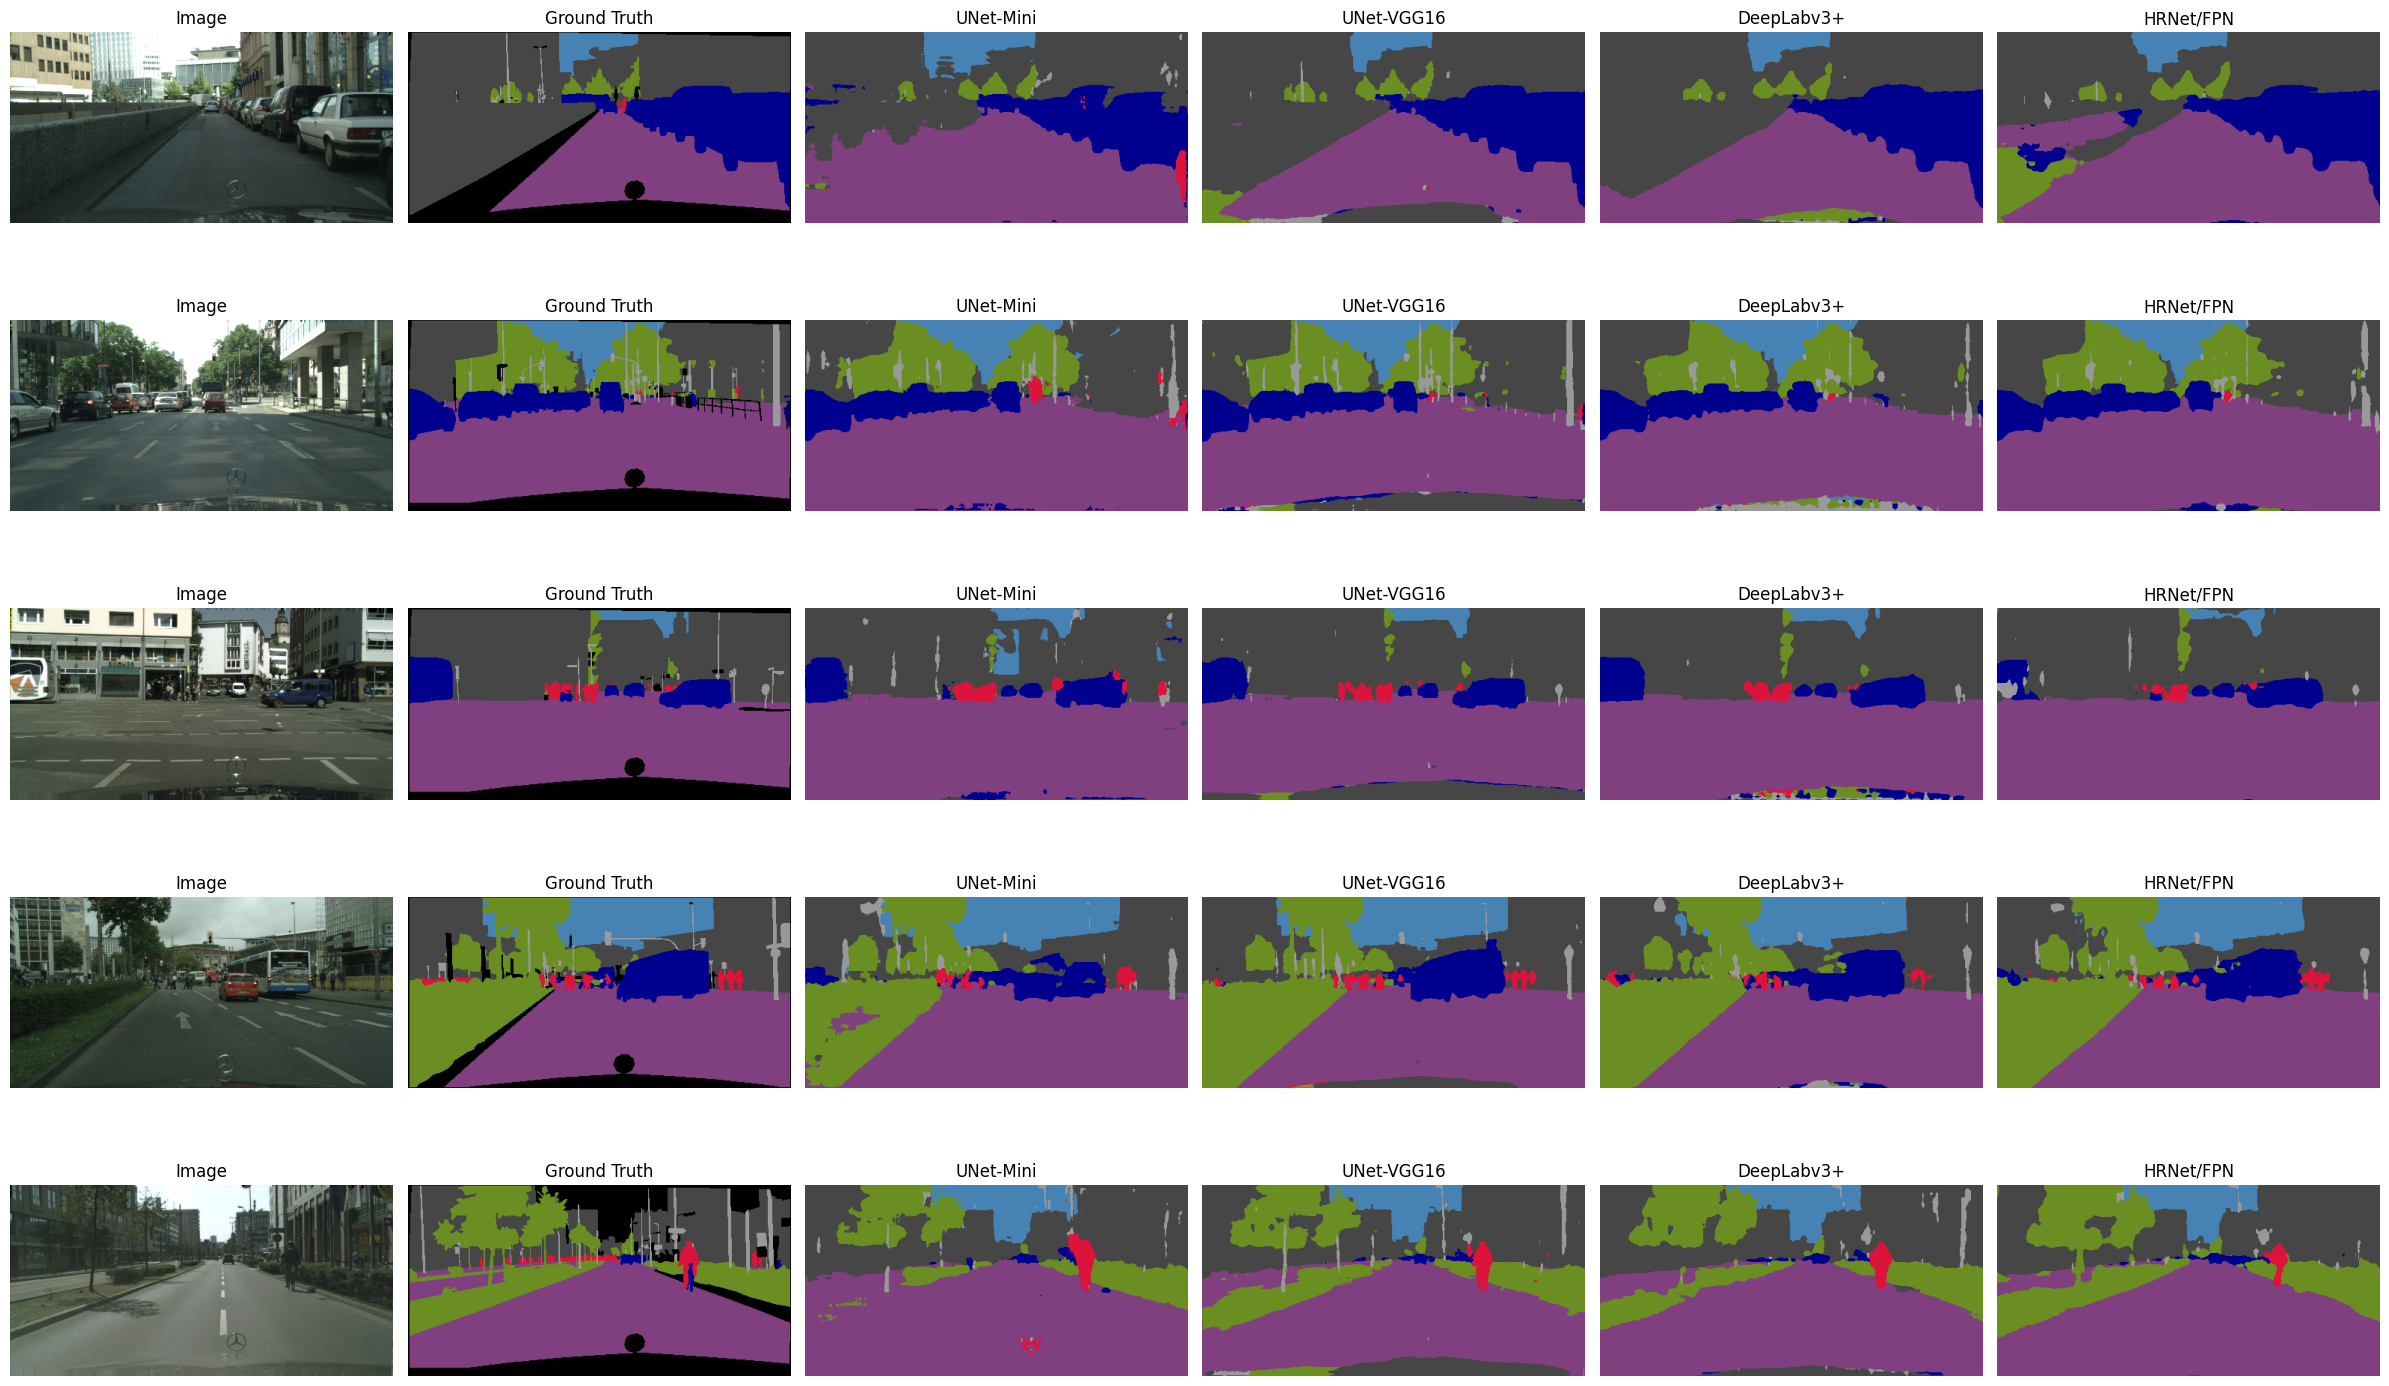

C:\Users\kilia\AppData\Local\Temp\ipykernel_16092\2748949984.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx = torch.cuda.amp.autocast(dtype=torch.float16) if use_amp else contextlib.nullcontext()


UNet-Mini    | time/img =    0.66 ms | mIoU = 0.6746 | Dice = 0.7594 | Params = 1,927,207
UNet-VGG16   | time/img =    1.38 ms | mIoU = 0.8119 | Dice = 0.8737 | Params = 26,676,103
DeepLabv3+   | time/img =    0.80 ms | mIoU = 0.7744 | Dice = 0.8413 | Params = 26,679,127
HRNet/FPN    | time/img =    0.93 ms | mIoU = 0.7742 | Dice = 0.8401 | Params = 11,171,463


In [67]:
# Charger checkpoints si disponibles (pour la cohérence des comparaisons)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# UNet-Mini
if os.path.exists(BEST_MODEL_FP):
    ck_mini = torch.load(BEST_MODEL_FP, map_location=device)
    model.load_state_dict(ck_mini['model'])
    miou_mini = ck_mini.get('miou', 'N/A')
    print(f"UNet-Mini ckpt chargé (mIoU: {miou_mini:.4f})")
else:
    print("UNet-Mini: pas de checkpoint trouvé, modèle courant utilisé.")
params_mini = count_params(model)
print(f"UNet-Mini: {params_mini:,} paramètres")

# UNet-VGG16
if os.path.exists(BEST_MODEL_VGG16_FP):
    ck_vgg = torch.load(BEST_MODEL_VGG16_FP, map_location=device)
    model_vgg16.load_state_dict(ck_vgg['model'])
    miou_vgg = ck_vgg.get('miou', 'N/A')
    print(f"UNet-VGG16 ckpt chargé (mIoU: {miou_vgg:.4f})")
else:
    print("UNet-VGG16: pas de checkpoint trouvé, modèle courant utilisé.")
params_vgg = count_params(model_vgg16)
print(f"UNet-VGG16: {params_vgg:,} paramètres")

# DeepLabv3+
if os.path.exists(BEST_MODEL_DEEPLAB_FP):
    ck_deeplab = torch.load(BEST_MODEL_DEEPLAB_FP, map_location=device)
    model_deeplab.load_state_dict(ck_deeplab['model'])
    miou_deeplab = ck_deeplab.get('miou', 'N/A')
    print(f"DeepLabv3+ ckpt chargé (mIoU: {miou_deeplab:.4f})")
else:
    print("DeepLabv3+: pas de checkpoint trouvé, modèle courant utilisé (poids pré-entraînés ImageNet ou init aléatoire).")
params_deeplab = count_params(model_deeplab)
print(f"DeepLabv3+: {params_deeplab:,} paramètres")

# HRNet
if os.path.exists(BEST_MODEL_HRNET_FP):
    ck_hrnet = torch.load(BEST_MODEL_HRNET_FP, map_location=device)
    model_hrnet.load_state_dict(ck_hrnet['model'])
    miou_hrnet = ck_hrnet.get('miou', 'N/A')
    print(f"HRNet ckpt chargé (mIoU: {miou_hrnet:.4f})")
else:
    print("HRNet: pas de checkpoint trouvé, modèle courant utilisé (poids pré-entraînés ImageNet ou init aléatoire).")
params_hrnet = count_params(model_hrnet)
print(f"HRNet/FPN: {params_hrnet:,} paramètres")

# Visualisation qualitative sur 5 images aléatoires

models_for_vis = [
    ("UNet-Mini", model),
    ("UNet-VGG16", model_vgg16),
    ("DeepLabv3+", model_deeplab),
    ("HRNet/FPN", model_hrnet),
]

# Prendre 5 indices aléatoires dans le validation set
import random

dataset = val_loader.dataset
data_len = len(dataset)
rand_indices = random.sample(range(data_len), 5)

imgs_list, masks_list = [], []

for idx in rand_indices:
    img, mask = dataset[idx]
    imgs_list.append(img.unsqueeze(0))
    masks_list.append(mask.unsqueeze(0))

imgs = torch.cat(imgs_list, dim=0).to(device)
masks = torch.cat(masks_list, dim=0)

with torch.no_grad():
    preds_stack = []
    for name, mdl in models_for_vis:
        mdl.eval()
        logits = mdl(imgs)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        preds_stack.append((name, preds))

# Préparer les images pour l'affichage
imgs_np = imgs.cpu().numpy()
imgs_np = np.transpose(imgs_np, (0,2,3,1))
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
imgs_vis = (imgs_np * std) + mean
imgs_vis = np.clip(imgs_vis, 0, 1)

gts = masks.numpy()

n = min(5, imgs_vis.shape[0])
cols = 2 + len(models_for_vis)
fig, axs = plt.subplots(n, cols, figsize=(4*cols, 3*n))
if n == 1:
    axs = np.array([axs])

for i in range(n):
    axs[i,0].imshow(imgs_vis[i]); axs[i,0].set_title('Image'); axs[i,0].axis('off')
    axs[i,1].imshow(coloriser_masque_8classes(gts[i].astype(np.uint8))); axs[i,1].set_title('Ground Truth'); axs[i,1].axis('off')
    for j, (name, preds) in enumerate(preds_stack, start=2):
        axs[i,j].imshow(coloriser_masque_8classes(preds[i].astype(np.uint8)))
        axs[i,j].set_title(name)
        axs[i,j].axis('off')
plt.tight_layout(); plt.show()

# Évaluation quantitative: temps moyen par image (ms), mIoU, Dice, nombre de paramètres
for name, mdl in models_for_vis:
    t_ms, miou, dice = evaluate_model_speed_and_metrics(mdl, val_loader, device=device)
    n_params = count_params(mdl)
    print(f"{name:12s} | time/img = {t_ms:7.2f} ms | mIoU = {miou:6.4f} | Dice = {dice:6.4f} | Params = {n_params:,}")


### temps de prédiction, miou, dice à rajouter

indice de jaccard - MIOU (intersection over union)

modèle unet mini, unet-vgg16

unet = segmention
vgg16 = classification

early stopping

dans l'api flask montrer le masque réel et le masque prédit

déployer sur le cloud l'api et l'app

temps de segmentation